In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm, trange

import arviz as az
import pymc as pm

from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal

ModuleNotFoundError: No module named 'numpy.distutils'

In [2]:
df = pd.read_csv("data/confirmed_daily_agg.csv")
print(df.shape)
df.head()

(193, 497)


,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21
0,Afghanistan,33.93911,67.709953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,453.0,505.0,406.0,242.0,547.0,628.0,840.0,623.0,764.0,981.0
1,Albania,41.15330,20.168300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.0,35.0,23.0,33.0,6.0,14.0,15.0,20.0,21.0,12.0
2,Algeria,28.03390,1.659600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,260.0,278.0,217.0,209.0,247.0,254.0,285.0,280.0,272.0,258.0
3,Andorra,42.50630,1.521800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,7.0,11.0,11.0,0.0
4,Angola,-11.20270,17.873900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,223.0,248.0,240.0,292.0,182.0,310.0,405.0,269.0,337.0,236.0


In [3]:
df_train = df.drop(columns=df.columns[-60:]).copy()
df_test = df.drop(columns=df.columns[3:-60]).copy()

df_train.shape, df_test.shape

((193, 437), (193, 63))

## Подготовка данных

Произведём агрегирование по странам и нормализуем. Стандартное отклонение можно считать по каждой стране отдельно, так как масштабы бедствия (в прямом смысле слова) сильно скоррелированны с населённостью. А вычитать среднее не будем, вместо него вычтем первое значение (которое 0), как это делают [здесь](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-MaunaLoa.html)

*В качестве альтернативны можно предложить просто взять заболеваемость, делённую на население страны, население можно считать константой. Это, скорее всего, также поможет более-менее уравнять масштабы, при этом меньше обуславливаясь на обучающую выборку*

Сначала построим гистограммы для не нормализованных данных. Если не выкидывать экстремальные значения, то видно лишь один столбец

Quantiles
[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 6.0000e+00 2.5000e+01
 8.3000e+01 2.5600e+02 6.8200e+02 2.1510e+03 3.0031e+05]


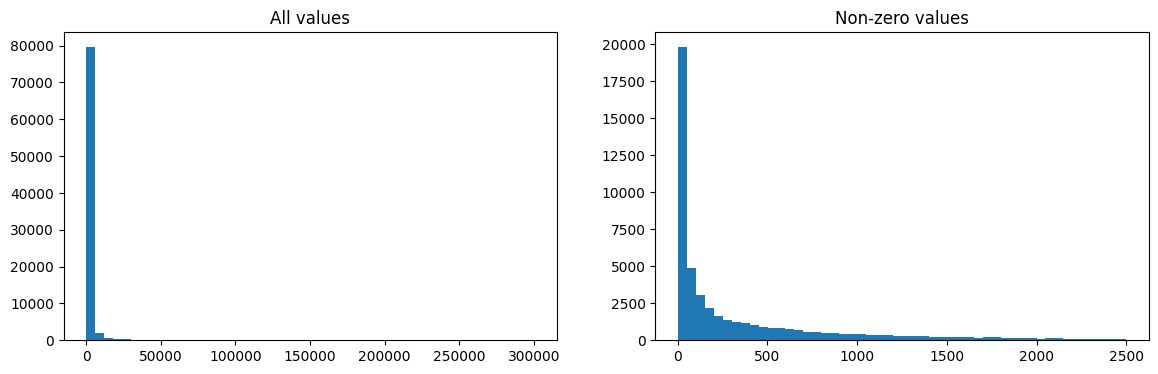

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

vals = df_train.iloc[:, 3:].values.flatten()
print("Quantiles")
print(np.quantile(vals, np.linspace(0, 1, 11)))

ax1.hist(vals, bins=50)
ax1.set_title("All values")

ax2.hist(vals[(vals > 0) & (vals < 2500)], bins=50)
ax2.set_title("Non-zero values")

plt.show()

Теперь посмотрим, что будет, если нормализовать

In [5]:
stats = {}
all_vals = df_train.iloc[:, 3:].values

stats["Country"] = df_train["Country/Region"].values
stats["First"] = all_vals[:, 0].copy()
stats["Mean"] = all_vals.mean(axis=1)
stats["Std"] = all_vals.std(axis=1)

stats_df = pd.DataFrame(stats)
stats_df.set_index("Country", inplace=True)
stats_df.head()

,First,Mean,Std
Country,,,
Afghanistan,0.0,126.658986,177.282011
Albania,0.0,287.380184,331.169281
Algeria,0.0,269.725806,243.414764
Andorra,0.0,27.336406,43.349530
Angola,0.0,51.099078,64.437923


In [6]:
df_train.iloc[:, 3:] -= stats_df["First"].values.reshape(-1, 1)
df_train.iloc[:, 3:] /= stats_df["Std"].apply(lambda x: x or 1).values.reshape(-1, 1)

df_test.iloc[:, 3:] -= stats_df["First"].values.reshape(-1, 1)
df_test.iloc[:, 3:] /= stats_df["Std"].apply(lambda x: x or 1).values.reshape(-1, 1)

Quantiles
[-0.57053459  0.          0.          0.          0.03353205  0.14609115
  0.3780085   0.74292089  1.27569953  2.08821609 20.85670898]


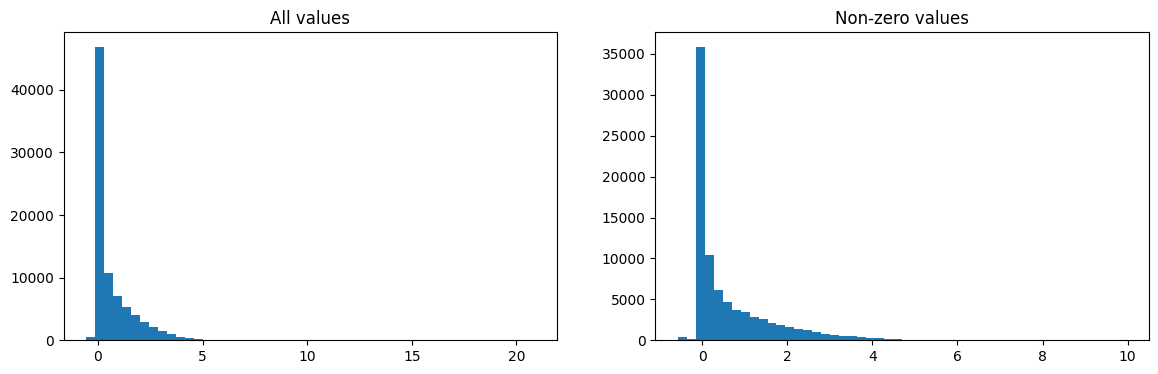

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

vals = df_train.iloc[:, 3:].values.flatten()
print("Quantiles")
print(np.quantile(vals, np.linspace(0, 1, 11)))

ax1.hist(vals, bins=50)
ax1.set_title("All values")

ax2.hist(vals[vals < 10], bins=50)
ax2.set_title("Non-zero values")

plt.show()

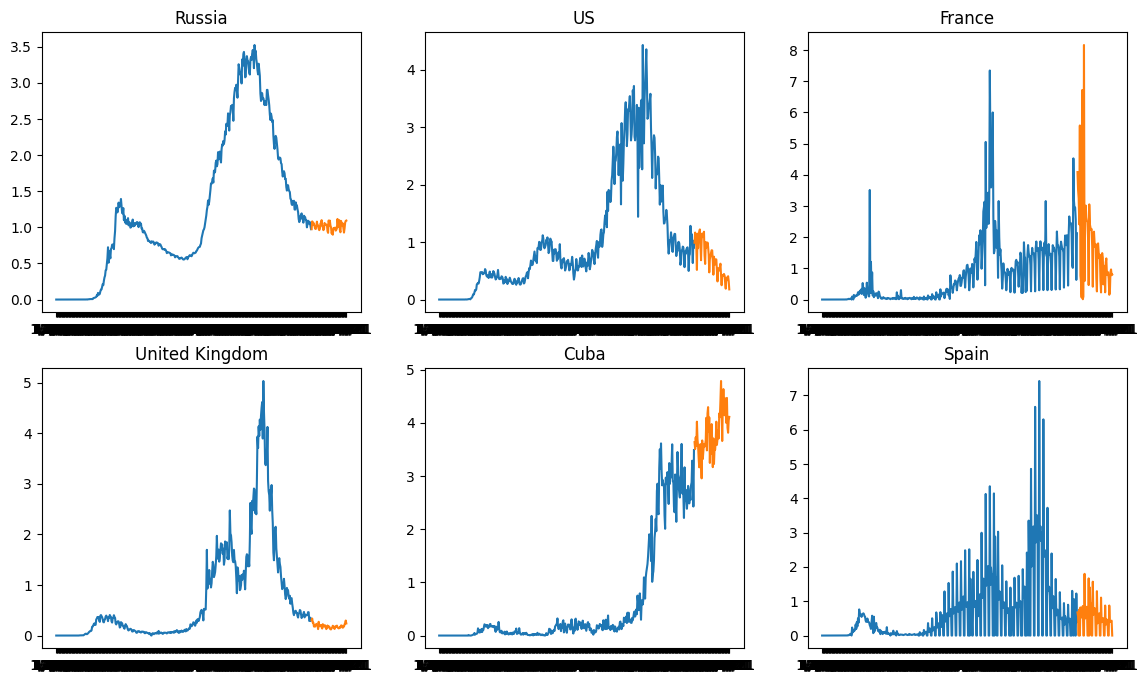

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(14, 8))
countries = ["Russia", "US", "France", "United Kingdom", "Cuba", "Spain"]

for i, country in enumerate(countries):
    ax[i // 3, i % 3].plot(df_train.columns[3:].tolist(), df_train[df_train["Country/Region"] == country].iloc[0, 3:].values)
    ax[i // 3, i % 3].plot(df_test.columns[3:].tolist(), df_test[df_test["Country/Region"] == country].iloc[0, 3:].values)
    ax[i // 3, i % 3].set_title(country)

plt.show()

По графикам нельзя заметить какой-тогодичной сезонности

А недельная сезонность (по дням недели) наблюдается. Это можно объяснить тем, что по выходным, например, люди сильнее перемешиваются, из-за чего после может расти заболеваемость

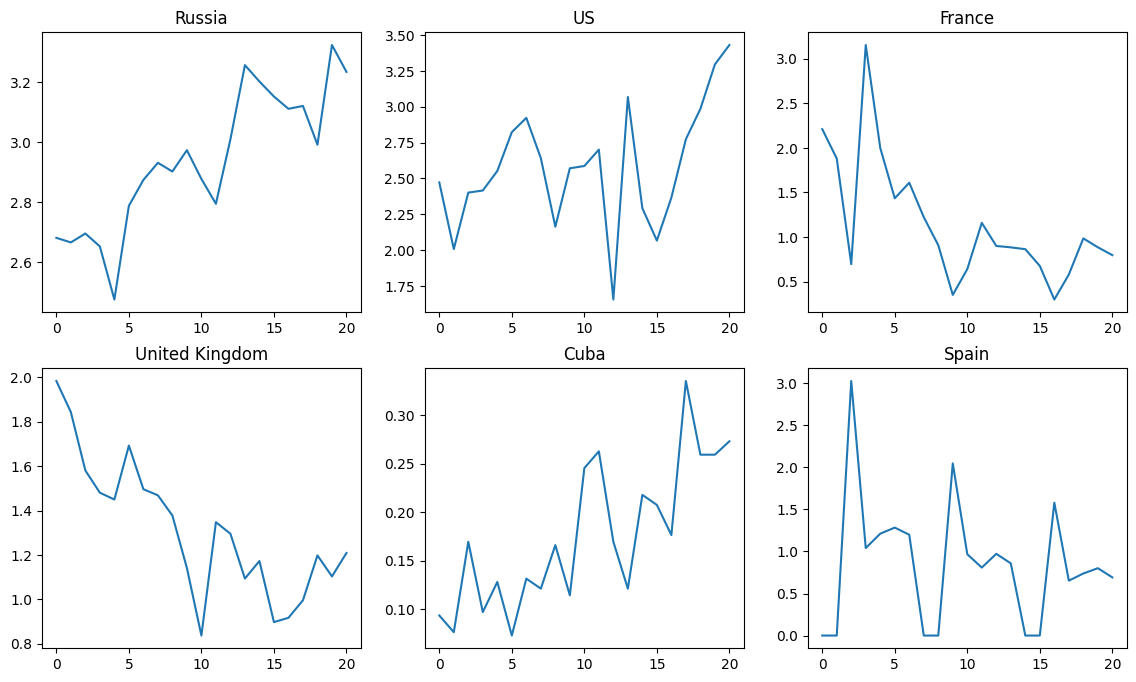

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(14, 8))
countries = ["Russia", "US", "France", "United Kingdom", "Cuba", "Spain"]

for i, country in enumerate(countries):
    ax[i // 3, i % 3].plot(df_train[df_train["Country/Region"] == country].iloc[0, 300:321].values)
    ax[i // 3, i % 3].set_title(country)

plt.show()

## Бейзлайн

### 1. Попробуем разложить ряд на тренд и сезонность
Сезонность, очевидно, недельная (что обосновано выше)

In [10]:
def decompose_time_series_additive(data, period=None, method='statsmodels'):
    if method == 'statsmodels':
        if period is None:
            ft = np.fft.fft(data)
            freqs = np.fft.fftfreq(len(data))
            positive_freqs = freqs[1:len(freqs)//2]
            amplitudes = np.abs(ft[1:len(freqs)//2])
            peak_freq_idx = np.argmax(amplitudes)
            period = int(1 / positive_freqs[peak_freq_idx])
        
        result = seasonal_decompose(
            data, 
            period=period, 
            extrapolate_trend='freq'
        )
        return result.trend, result.seasonal, result.resid
    
    elif method == 'custom':
        data = np.array(data)
        
        if period is None:
            period = 7
            
        trend = pd.Series(data).rolling(
            window=period, 
            center=True, 
            min_periods=1
        ).mean().values
        
        detrended = data - trend
        
        seasonal_pattern = np.zeros(period)
        for i in range(period):
            seasonal_pattern[i] = np.mean(detrended[i::period])
            
        seasonal = np.tile(seasonal_pattern, len(data)//period + 1)[:len(data)]
        residual = data - trend - seasonal
        return trend, seasonal, residual
    
    else:
        raise ValueError("Method should be 'statsmodels' or 'custom'")


def decompose_time_series_multiplicative(data, period=None):
    result = seasonal_decompose(
        data, 
        period=period if period else 12, 
        model='multiplicative',
        extrapolate_trend='freq'
    )
    
    return result.trend, result.seasonal, result.resid

In [11]:
trend_df, season_df = df_train.copy(), df_train.copy()

for i in trange(len(df_train)):
    t, s, r = decompose_time_series_additive(df_train.iloc[i, 3:].values, period=7, method='custom')
    trend_df.iloc[i, 3:] = t
    season_df.iloc[i, 3:] = s

  0%|          | 0/193 [00:00<?, ?it/s]

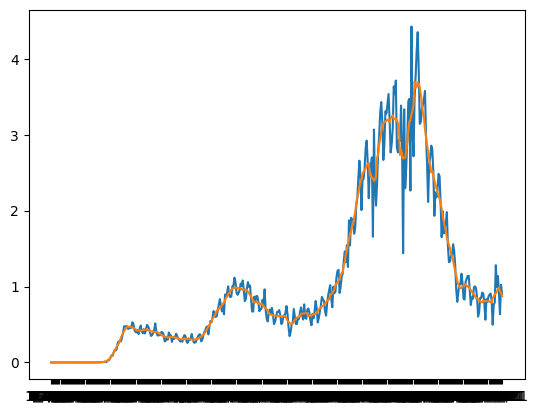

In [12]:
plt.plot(df_train[df_train["Country/Region"] == "US"].iloc[0, 3:])
plt.plot(trend_df[trend_df["Country/Region"] == "US"].iloc[0, 3:])
plt.show()

Всё равно не супер очевидно, что делать с таким трендом. На линейную функцию он не тянет, на логарифмы тоже. Можно попробовать регрессию с полиномиальными фичами, но в неё тоже не сильно верится, поэтому давайте попробуем сразу иерархический гауссовский процесс

## Построение модели

Для начала сузимся на несколько стран

Пусть это будут Россия, США, Италия, Франция, Испания, Великобритания, Германия, Куба, Казахстан и Беларусь

In [49]:
countries3 = {"US", "United Kingdom", "Germany"}
df_train_ten = df_train[df_train["Country/Region"].apply(lambda x: x in countries3)]
df_test_ten = df_test[df_test["Country/Region"].apply(lambda x: x in countries3)]

print(df_train_ten.shape)
df_train.head()

(3, 437)


,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21
0,Afghanistan,33.93911,67.709953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.056407,0.282037,0.135378,0.084611,0.191785,0.157940,0.203066,0.022563,0.157940,0.349725
1,Albania,41.15330,20.168300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.989919,1.038744,0.914940,1.352782,1.425253,1.355802,1.283332,1.488665,0.860587,0.917960
2,Algeria,28.03390,1.659600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.373847,0.402605,0.386172,0.365631,0.431362,0.468336,0.382064,0.353306,0.451904,0.472445
3,Andorra,42.50630,1.521800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.830459,0.645912,1.061142,1.084210,1.130347,1.038074,1.776259,0.945800,0.876595,1.291825
4,Angola,-11.20270,17.873900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.574196,0.372451,0.263820,0.962166,1.210467,0.729384,1.086317,0.496602,1.070798,0.775941


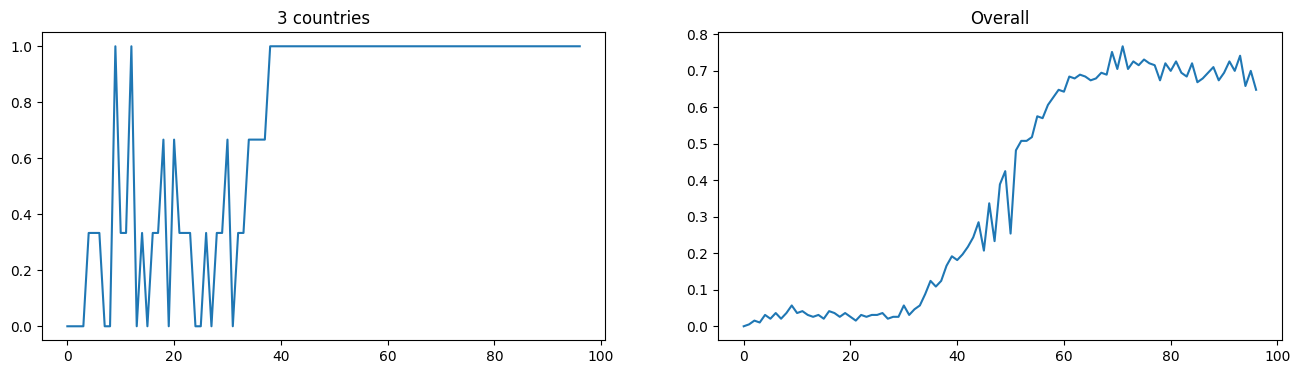

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot((df_train_ten.iloc[:, 3:100].values > 0).sum(axis=0) / len(df_train_ten))
ax1.set_title("3 countries")

ax2.plot((df_train.iloc[:, 3:100].values > 0).sum(axis=0) / len(df_train))
ax2.set_title("Overall")

plt.show()

Перестроим датасет, что было 1 строка $\to$ 1 замерение

Возьмём данные с 40-го дня измерений, когда хотя бы в половине рассматриваемых стран начались заражения

In [51]:
data = {
    "date": [],
    "country": [],
    "lat": [],
    "lon": [],
    "y": [],
}

for i in trange(len(df_train_ten)):
    for k in range(43, df_train_ten.shape[1]):
        data["country"].append(df_train_ten.iloc[i, 0])
        data["lat"].append(df_train_ten.iloc[i, 1])
        data["lon"].append(df_train_ten.iloc[i, 2])
        data["date"].append(df_train_ten.columns[k])
        data["y"].append(df_train.iloc[i, k])

data = pd.DataFrame(data)
data["date"] = pd.to_datetime(data["date"])
data.sort_values(by=["date", "country"], inplace=True)
data.index = np.arange(len(data))

print(data.shape)
data.head()

  0%|          | 0/3 [00:00<?, ?it/s]

(1182, 5)


/tmp/ipykernel_252546/95667591.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["date"] = pd.to_datetime(data["date"])


,date,country,lat,lon,y
0,2020-03-02,Germany,51.165691,10.451526,0.000000
1,2020-03-02,US,40.000000,-100.000000,0.000000
2,2020-03-02,United Kingdom,21.840266,-41.440047,0.008216
3,2020-03-03,Germany,51.165691,10.451526,0.005641
4,2020-03-03,US,40.000000,-100.000000,0.000000


In [54]:
# Координаты
X_geo = data.iloc[:3, 2:4].values
X_geo.shape

(3, 2)

In [55]:
# Показатели
y = df_train_ten.iloc[:, 43:].values.T
y.shape

(394, 3)

In [56]:
X_time = np.arange(y.shape[0])
X_time = (X_time - X_time.mean()) / X_time.std() * 10
X_time.shape

(394,)

## Gaussian process

Построим Гауссовский процесс, состоящий из следующих компонент:
- Глобальный тренд
- Локальные тренды с "более короткой" ковариацией
- Компонента, зависящая от расстояния между городами
- Сезонность по дням недели (амплитуда зависит от города)

In [57]:
class ExpQuadChordal(pm.gp.cov.Covariance):
    """
    Экспоненциально-квадратичное ядро, использующее хордовое расстояние для сферических координат.
    """

    def __init__(self, input_dim, ls, R=6371.0):
        super().__init__(input_dim=input_dim)
        self.R = R
        self.ls = ls
    
    def _haversine_distance(self, X1, X2):
        lat1, lon1 = np.radians(X1[:, 0:1]), np.radians(X1[:, 1:2])
        lat2, lon2 = np.radians(X2[:, 0:1]), np.radians(X2[:, 1:2])
        
        dlat = lat2.T - lat1
        dlon = lon2.T - lon1
        
        a = np.sin(dlat/2)**2 + \
            np.cos(lat1) * np.cos(lat2.T) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        return self.R * c
    
    def full(self, X1, X2=None):
        if X2 is None:
            X2 = X1
        d = self._haversine_distance(X1, X2)
        K = np.exp(-(d**2) / (2 * self.ls**2))
        return K

In [58]:
# X_time,          # время, shape: (n_days,)
# X_geo,           # координаты стран, shape: (n_countries, 2)
# y,               # наблюдения, shape: (n_days, n_countries)
    
n_days, n_countries = y.shape

coords = {
    "country": df_train_ten["Country/Region"].values,
    "time": data["date"].unique(),
}
with pm.Model() as model:
    # 1. Глобальный тренд
    ls_main = pm.Gamma("ls_main", mu=5, sigma=2)
    amplitude_main = pm.HalfNormal("amplitude_main", sigma=1.0)
    
    cov_main = amplitude_main ** 2 * pm.gp.cov.ExpQuad(1, ls_main)
    gp_main = pm.gp.Latent(cov_func=cov_main)
    main_trend = gp_main.prior(
        "main_trend",
        X_time.reshape(-1, 1),
        dims="time",
        jitter=1e-7
    )

    # 2. Недельная сезонность
    ls_weekly = pm.Gamma("ls_weekly", mu=2, sigma=0.5)
    amplitude_weekly = pm.HalfNormal("amplitude_weekly", sigma=0.5, shape=n_countries)
    cov_weekly = pm.gp.cov.Periodic(1, period=7, ls=ls_weekly)
    gp_weekly = pm.gp.Latent(cov_func=cov_weekly)
    weekly_base = gp_weekly.prior(
        "weekly_base",
        X_time.reshape(-1, 1),
        dims="time",
        jitter=1e-7
    )
    weekly_effect = pm.Deterministic(
        "weekly_effect",
        weekly_base[:, None] * amplitude_weekly[None, :]
    )
    
    # 3. Компонента зависимости между городами
    ls_spatial = pm.Gamma("ls_spatial", mu=300, sigma=75)
    amplitude_spatial = pm.HalfNormal("amplitude_spatial", sigma=1.0, shape=n_countries)
    cov_spatial = amplitude_spatial ** 2 * ExpQuadChordal(2, ls_spatial)
    gp_spatial = pm.gp.Latent(cov_func=cov_spatial)
    spatial_effect = gp_spatial.prior("spatial_effect", X_geo, dims="country", jitter=1e-7)

    local_trends = []
    ls_locals, amplitudes_locals, cov_mains = [], [], []
    gp_locals = []
    for i in range(n_countries):
        ls_locals.append(pm.Gamma(f"ls_local_{i}", mu=2, sigma=2))
        amplitudes_locals.append(pm.HalfNormal(f"amplitude_main_{i}", sigma=1.0))
        cov_mains.append(amplitudes_locals[-1] ** 2 * pm.gp.cov.ExpQuad(1, ls_locals[-1]))
        gp_locals.append(pm.gp.Latent(cov_func=cov_mains[-1]))
        local_trends.append(gp_locals[-1].prior(
            f"local_trend_{i}",
            X_time.reshape(-1, 1),
            dims="time",
            jitter=1e-7
        ))
    local_trends = pm.math.stack(local_trends).T
    # print(local_trends.shape.eval())
    
    # СОБИРАЕМ ВСЁ ВМЕСТЕ
    expected_cases = main_trend[:, None] + weekly_effect + spatial_effect[None, :] + local_trends
        
    sigma = pm.HalfNormal("sigma", sigma=1.0)
    
    y_obs = pm.Normal(
        "y_obs",
        mu=expected_cases,
        sigma=sigma,
        observed=y
    )

In [59]:
# with model:
#     trace = pm.sample(1000, tune=1000)

# if time_left < time_do_examena:
#     break :(

Посмотрим на параметры апостериорного распределения

In [ ]:
with model:
    map_estimation = pm.find_MAP()

Output()

In [ ]:
map_estimation.keys()

In [ ]:
for key, value in map_estimation.items():
    if key.endswith("_"):
        continue
    if len(value.shape) > 0:
        continue
    print(key, value)

In [ ]:
with model:
    gp = gp_main + gp_weekly
    x = gp.predict(np.arange(394 + 60).reshape(-1, 1), point=map_estimation, diag=True)

In [224]:
# X_time,          # время, shape: (n_days,)
# X_geo,           # координаты городов, shape: (n_countries, 2)
# y,               # наблюдения, shape: (n_days, n_countries)
    
n_days, n_countries = y.shape

coords = {
    "country": df_train_ten["Country/Region"].values,
    "time": data["date"].unique(),
}
with pm.Model() as model2:
    # 1. Глобальный тренд
    ls_main = pm.Gamma("ls_main", mu=7, sigma=2)
    amplitude_main = pm.HalfNormal("amplitude_main", sigma=1.0)
    
    cov_main = amplitude_main ** 2 * pm.gp.cov.ExpQuad(1, ls_main)
    gp_main = pm.gp.Latent(cov_func=cov_main)
    main_trend = gp_main.prior(
        "main_trend",
        X_time.reshape(-1, 1),
        dims="time",
        jitter=1e-7
    )

    # 2. Недельная сезонность
    ls_weekly = pm.Gamma("ls_weekly", mu=2, sigma=0.5)
    amplitude_weekly = pm.HalfNormal("amplitude_weekly", sigma=0.5, shape=n_countries)
    cov_weekly = pm.gp.cov.Periodic(1, period=7, ls=ls_weekly)
    gp_weekly = pm.gp.Latent(cov_func=cov_weekly)
    weekly_base = gp_weekly.prior(
        "weekly_base",
        X_time.reshape(-1, 1),
        dims="time",
        jitter=1e-7
    )
    weekly_effect = pm.Deterministic(
        "weekly_effect",
        weekly_base[:, None] * amplitude_weekly[None, :]
    )
    
    # 3. Компонента зависимости между странами
    ls_spatial = pm.Gamma("ls_spatial", mu=300, sigma=75)
    amplitude_spatial = pm.HalfNormal("amplitude_spatial", sigma=1.0)
    cov_spatial = amplitude_spatial ** 2 * ExpQuadChordal(2, ls_spatial)
    gp_spatial = pm.gp.Latent(cov_func=cov_spatial)
    spatial_effect = gp_spatial.prior(
        "spatial_effect",
        X_geo,
        dims="country",
        jitter=1e-7
    )
    
    # СОБИРАЕМ ВСЁ ВМЕСТЕ
    print(main_trend.shape.eval())
    print(weekly_effect.shape.eval())
    print(spatial_effect.shape.eval())

    expected_cases = (
        main_trend[:, None] +          # (n_days, 1)
        weekly_effect +                # (n_days, n_countries)
        spatial_effect[None, :]        # (1, n_countries)
    )
    sigma = pm.HalfNormal("sigma", sigma=1.0)
    
    y_obs = pm.Normal(
        "y_obs",
        mu=expected_temp,
        sigma=sigma,
        observed=y
    )

[394]
[394  10]
[10]


In [225]:
with model2:
    map_estimation2 = pm.find_MAP()

ValueError: Random variables detected in the logp graph: {city_trend_mu, city_trend_sigma, main_trend_rotated_, ls_spatial, amplitude_spatial, ls_main, ls_weekly, amplitude_main, spatial_effect_rotated_, amplitude_weekly, weekly_base_rotated_}.
This can happen when DensityDist logp or Interval transform functions reference nonlocal variables,
or when not all rvs have a corresponding value variable.